In [1]:
import sys
sys.path.append('..')
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from utils import *
from networks import *

import matplotlib.pyplot as plt
from optax.contrib import reduce_on_plateau
import optax

In [5]:
running_on = "local"
problem = "kdv"
model = "fno2d"

if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    trainer_path = "C:/Users/eirik/orbax/"
elif running_on == "idun":
    data_path = "/cluster/work/eirikaf/data/"
else:
    raise ValueError("Invalid running_on")

scaled_data = jnp.load(data_path + problem + "_scaled_data.npz")
a_train_s = jnp.array(scaled_data["a_train_s"])
u_train_s = jnp.array(scaled_data["u_train_s"])
a_val_s = jnp.array(scaled_data["a_val_s"])
u_val_s = jnp.array(scaled_data["u_val_s"])

x_train_s = jnp.array(scaled_data["x_train_s"])
t_train_s = jnp.array(scaled_data["t_train_s"])

In [6]:
trainer_instance = Trainer.from_checkpoint(trainer_path + model + "_" + problem, 
                                           FNO2d)

TypeError: Hparams.__init__() missing 1 required keyword-only argument: 'P'

In [16]:
path = "C:/Users/eirik/orbax/fno1d_kdv"
path = epath.Path(path)
    
# First load the hparams
with open(path / 'hparams.json', "rb") as f:
    hparams = json.load(f)
    
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:

θ_optimizer = optax.chain(
    optax.adam(hparams["learning_rate"]),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

if hparams["λ_learning_rate"]:
    λ_optimizer = optax.chain(optax.adam(hparams["λ_learning_rate"]), optax.scale(-1.))
    opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
else:
    opt = θ_optimizer

trainer_fno1d = load_checkpoint("C:/Users/eirik/orbax/fno1d_kdv", FNO1d, opt, train_loader, val_loader)

In [56]:
path = "C:/Users/eirik/orbax/hno_kdv"
path = epath.Path(path)
    
# First load the hparams
with open(path / 'hparams.json', "rb") as f:
    hparams_operator_net = json.load(f)
    
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:

θ_optimizer = optax.adam(hparams["learning_rate"])

if hparams["λ_learning_rate"]:
    λ_optimizer = optax.chain(optax.adam(hparams["λ_learning_rate"]), optax.scale(-1.))
    opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
else:
    opt = θ_optimizer
    

operator_net = ModifiedDeepONet(hparams_operator_net["operator_net"])
hparams_energy_net = hno.EnergyNetHparams(depth=5, width=100, learning_rate=1e-3)
energy_net = hno.EnergyNet(hparams_energy_net)

abstract_model = hno.HamiltonianNeuralOperatorDON(energy_net, operator_net)

with ocp.CheckpointManager(path) as mngr:
    epoch_idx = mngr.latest_step()
    restored = mngr.restore(
        epoch_idx, 
        args=ocp.args.Composite(
            model=EquinoxStateRestore(abstract_model),
            #opt_state=ocp.args.StandardRestore(abstract_opt_state),
            loss_history=ocp.args.StandardRestore(),
            #λ_history=ocp.args.StandardRestore(),
        )
    )
    
# Initialize the trainer with the restored model, optimizer state and training history
model_hno = restored.model
loss_history = restored.loss_history

#trainer_fno1d = load_checkpoint("C:/Users/eirik/orbax/fno1d_kdv", FNO1d, opt, train_loader, val_loader)

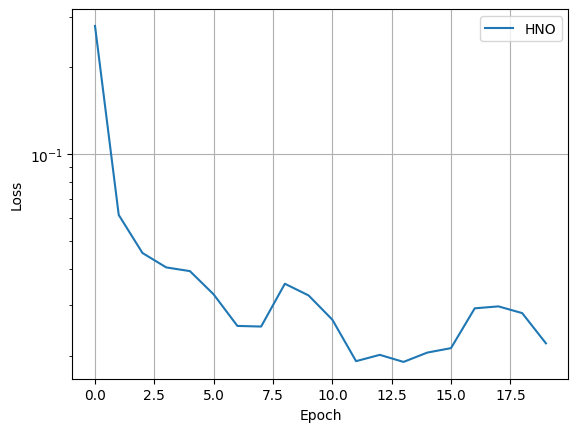

In [55]:
plt.plot(loss_history["train_loss_history"][:20], label="HNO")
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [57]:
u_pred_hno = model_hno.predict_whole_grid(a_test_n[0][::4], x_n, t_n)

ValueError: `terms` must be a PyTree of `AbstractTerms` (such as `ODETerm`), with structure <class 'diffrax._term.AbstractTerm'>

In [ ]:
u_pred_hno = model_hno.predict_whole_grid(a_test_n[0][::4], x_n, t_n)

ValueError: `terms` must be a PyTree of `AbstractTerms` (such as `ODETerm`), with structure <class 'diffrax._term.AbstractTerm'>

In [18]:
path = "C:/Users/eirik/orbax/fno2d_kdv"
path = epath.Path(path)
    
# First load the hparams
with open(path / 'hparams.json', "rb") as f:
    hparams = json.load(f)
    
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:

θ_optimizer = optax.chain(
    optax.adam(hparams["learning_rate"]),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

if hparams["λ_learning_rate"]:
    λ_optimizer = optax.chain(optax.adam(hparams["λ_learning_rate"]), optax.scale(-1.))
    opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
else:
    opt = θ_optimizer

trainer_fno2d = load_checkpoint("C:/Users/eirik/orbax/fno2d_kdv", FNO2d, opt, train_loader, val_loader)

In [19]:
path = "C:/Users/eirik/orbax/modified_deeponet_kdv"
path = epath.Path(path)
    
# First load the hparams
with open(path / 'hparams.json', "rb") as f:
    hparams = json.load(f)
    
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:

θ_optimizer = optax.chain(
    optax.adam(hparams["learning_rate"]),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

if hparams["λ_learning_rate"]:
    λ_optimizer = optax.chain(optax.adam(hparams["λ_learning_rate"]), optax.scale(-1.))
    opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
else:
    opt = θ_optimizer

trainer_mod_don = load_checkpoint("C:/Users/eirik/orbax/modified_deeponet_kdv", ModifiedDeepONet, opt, train_loader, val_loader)

In [28]:
def plot_loss(trainers, port=8050):
    """
    Plots the loss history of multiple trainers on the same plot.
    
    Args:
        trainers (dict): A dictionary where keys are trainer names (str) 
                         and values are trainer objects.
        port (int): Port to run the Dash app on.
    """
    app = dash.Dash(external_stylesheets=[dbc.themes.MATERIA])
    
    # Define layout
    config = {
        'toImageButtonOptions': {
            'format': 'svg', 
            'filename': 'loss_plot',
        }
    }
                
    app.layout = dbc.Container([
        dbc.Row(dcc.Graph(id="loss-plot", config=config)),
        dbc.Row([
            dbc.Col(dbc.Switch(
                id="toggle-markers",
                label="Show Markers",
                value=True,  # Default to show markers
            ), width=3),
            dbc.Col(dbc.Switch(
                id="toggle-batch-loss",
                label="Show Batch Loss",
                value=True,  # Default to show batch loss
            ), width=3),
            dbc.Col(dbc.Switch(
                id="toggle-train",
                label="Show Train Loss",
                value=True,  # Default to show batch loss
            ), width=3),
            dbc.Col(dbc.Switch(
                id="toggle-val",
                label="Show Val Loss",
                value=True,  # Default to show batch loss
            ), width=3),
        ], justify='start'),
    ])

    # Callback to update the plot based on toggle states
    @app.callback(
        Output("loss-plot", "figure"),
        [Input("toggle-markers", "value"),
         Input("toggle-batch-loss", "value"),
         Input("toggle-train", "value"),
         Input("toggle-val", "value"),]
    )
    def update_plot(show_markers, show_batch, show_train, show_val):
        fig = go.Figure()

        # Define colors for the trainers
        colors = ['#bc5090', '#ffa600', '#003f5c', '#58508d', '#ff6361']
        color_cycle = iter(colors)

        for trainer_name, trainer in trainers.items():
            trainer_color = next(color_cycle, '#000000')  # Default to black if colors run out

            # Add batch loss traces if show_batch is enabled
            if show_batch:
                if show_train:
                    fig.add_trace(go.Scatter(
                        x=jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history_batch)),
                        y=trainer.train_loss_history_batch,
                        mode='lines',
                        line=dict(color=trainer_color, width=1),
                        opacity=0.3,
                        name=f'{trainer_name} - Batch Train',
                        legendgroup=f'{trainer_name}-train'
                    ))
                if show_batch:
                    fig.add_trace(go.Scatter(
                        x=jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history_batch)),
                        y=trainer.val_loss_history_batch,
                        mode='lines',
                        line=dict(color=trainer_color, width=1, dash='dot'),
                        opacity=0.3,
                        name=f'{trainer_name} - Batch Val',
                        legendgroup=f'{trainer_name}-val'
                    ))

            # Add epoch loss traces with optional markers
            if show_train:
                fig.add_trace(go.Scatter(
                    x=jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history)),
                    y=trainer.train_loss_history,
                    line=dict(color=trainer_color, width=2),
                    name=f'{trainer_name}',
                    mode='lines+markers' if show_markers else 'lines',
                    legendgroup=f'{trainer_name}-train',
                    legendgrouptitle=dict(text=f'{trainer_name} - Train'),
                ))

            if show_val:
                fig.add_trace(go.Scatter(
                    x=jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history)),
                    y=trainer.val_loss_history,
                    line=dict(color=trainer_color, width=2),
                    name=f'{trainer_name}',
                    mode='lines+markers' if show_markers else 'lines',
                    legendgroup=f'{trainer_name}-val',
                    legendgrouptitle=dict(text=f'{trainer_name} - Validation'),
                ))

        fig.update_layout(
            title='Loss History for KdV',
            legend=dict(x=1, y=1),
            template='seaborn',
            xaxis=dict(title="Epoch"),
            yaxis=dict(title="Relative l2 loss", type='log', tickformat='.1e'),
        )

        return fig

    app.run(port=port)

In [29]:
plot_loss({'FNO1d': trainer_fno1d, 'FNO2d': trainer_fno2d, 'Modified DeepONet': trainer_mod_don})

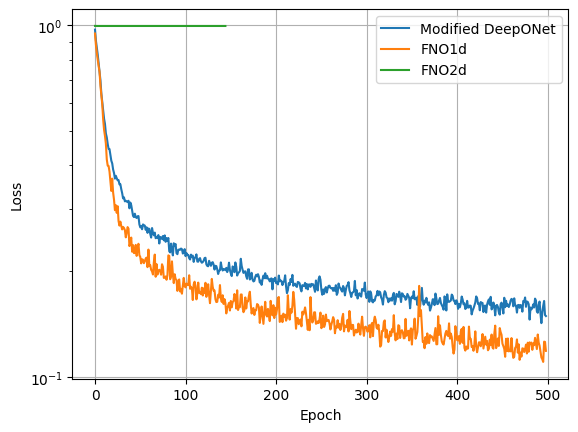

In [13]:
plt.figure()
plt.plot(train_loss_history_mod_don, label='Modified DeepONet')
plt.plot(train_loss_history_fno1d, label='FNO1d')
plt.plot(train_loss_history_fno2d, label='FNO2d')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

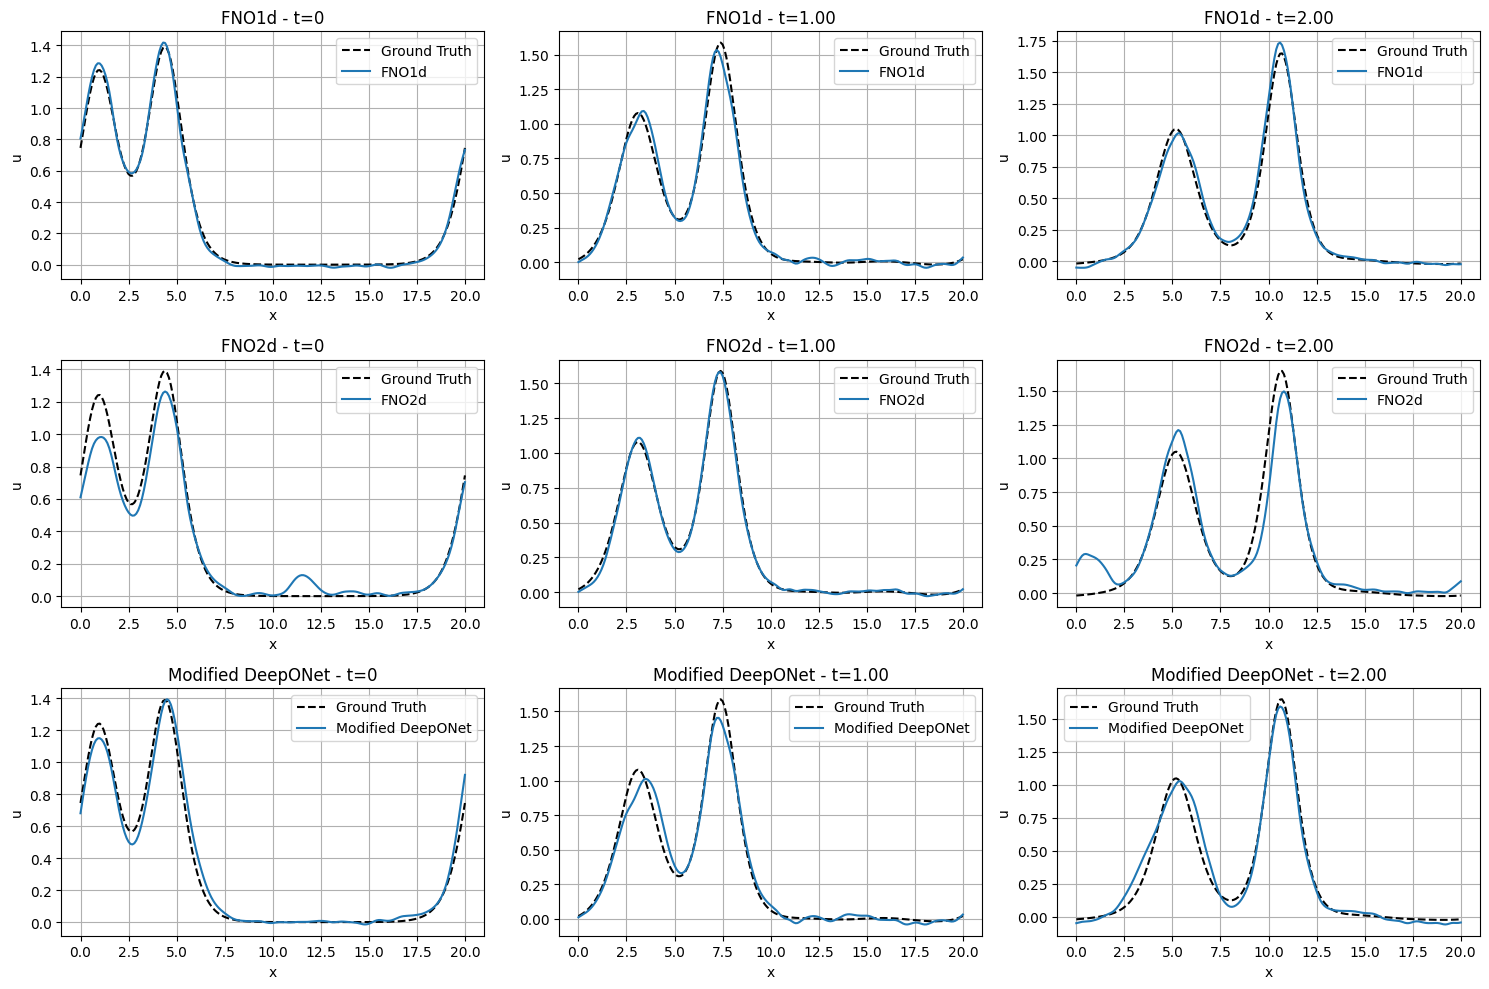

In [46]:
sample_idx = 88

u_pred_fno2d = u_normalizer.decode(trainer_fno2d.model.predict_whole_grid(a_test_n[sample_idx], x_n, t_n))
u_pred_fno1d = u_normalizer.decode(trainer_fno1d.model.predict_whole_grid(a_test_n[sample_idx], x_n, t_n))
u_pred_mod_don = u_normalizer.decode(trainer_mod_don.model.predict_whole_grid(a_test_n[sample_idx][::4], x_n, t_n))
time_indices = [0, len(t) // 2, -1]  # Start, middle, and end time indices
time_labels = ['t=0', f't={t[len(t) // 2]:.2f}', f't={t[-1]:.2f}']

plt.figure(figsize=(15, 10))

for i, time_idx in enumerate(time_indices):
    plt.subplot(3, len(time_indices), i + 1)
    plt.plot(x, u_test[sample_idx, time_idx, :], 'k--', label='Ground Truth')
    plt.plot(x, u_pred_fno1d[time_idx, :], label='FNO1d')
    plt.title(f'FNO1d - {time_labels[i]}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid()

    plt.subplot(3, len(time_indices), i + 1 + len(time_indices))
    plt.plot(x, u_test[sample_idx, time_idx, :], 'k--', label='Ground Truth')
    plt.plot(x, u_pred_fno2d[time_idx, :], label='FNO2d')
    plt.title(f'FNO2d - {time_labels[i]}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid()

    plt.subplot(3, len(time_indices), i + 1 + 2 * len(time_indices))
    plt.plot(x, u_test[sample_idx, time_idx, :], 'k--', label='Ground Truth')
    plt.plot(x, u_pred_mod_don[time_idx, :], label='Modified DeepONet')
    plt.title(f'Modified DeepONet - {time_labels[i]}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [26]:
plot_predictions(u_test_n, a_test_n, x_n, t_n, model_fno1d, model_names = ["FNO1d"])